<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li><li><span><a href="#Blend" data-toc-modified-id="Blend-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Blend</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


### Load imports and dfs

In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings
import gc

In [3]:
train_df2 = feather.read_dataframe('train_df_3691')
test_df2 = feather.read_dataframe('test_df_3691')

In [4]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [5]:
cols_excluded = ['purchase_date_max', 'purchase_date_max_old', 'card_id', 'first_active_month',
                 'target','outliers','card_id_size', 'card_id_size_old', 
                 'purchase_date_min', 'purchase_date_min_old','first_active_monthYear',
                 'first_active_monthMonth',
                 'first_active_monthWeek',
                 'first_active_monthDay',
                 'first_active_monthDayofweek',
                 'first_active_monthDayofyear',
                 'first_active_monthIs_month_end',
                 'first_active_monthIs_month_start',
                 'first_active_monthIs_quarter_end',
                 'first_active_monthIs_quarter_start',
                 'first_active_monthIs_year_end',
                 'first_active_monthIs_year_start']

In [6]:
df_train_columns = [c for c in train_df2.columns if c not in cols_excluded]
target = train_df2['target']

In [7]:
train_df2.shape, test_df2.shape

((201917, 203), (123623, 201))

In [8]:
target.shape

(201917,)

In [9]:
del train_df2['target']

In [10]:
len(df_train_columns)

181

In [119]:
df_train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'first_active_monthElapsed',
 'transactions_count',
 'subsector_id_nunique',
 'merchant_id_nunique',
 'merchant_category_id_nunique',
 'purchase_Month_mean',
 'purchase_Month_min',
 'purchase_Month_max',
 'purchase_Week_nunique',
 'purchase_Week_mean',
 'purchase_Week_min',
 'purchase_Week_max',
 'purchase_Dayofweek_mean',
 'purchase_Dayofweek_min',
 'purchase_Dayofweek_max',
 'purchase_Day_nunique',
 'purchase_Day_mean',
 'purchase_Day_min',
 'purchase_Day_max',
 'purchase_Hour_nunique',
 'purchase_Hour_mean',
 'purchase_Hour_min',
 'purchase_Hour_max',
 'purchase_amount_sum',
 'purchase_amount_max',
 'purchase_amount_min',
 'purchase_amount_mean',
 'purchase_amount_var',
 'purchase_amount_skew',
 'installments_sum',
 'installments_max',
 'installments_mean',
 'installments_var',
 'installments_skew',
 'month_lag_max',
 'month_lag_min',
 'month_lag_mean',
 'month_lag_var',
 'month_lag_skew',
 'month_diff_mean',
 'month_diff_var',
 'month_diff

In [11]:
n_fold =5

In [12]:
param = {
        'task': 'train',
        'boosting': 'goss',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 123,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':int(2**n_fold),
        'bagging_seed':int(2**n_fold),
        'drop_seed':int(2**n_fold)
        }
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.6486	valid_1's rmse: 3.71202
[200]	training's rmse: 3.56235	valid_1's rmse: 3.67577
[300]	training's rmse: 3.50776	valid_1's rmse: 3.66326
[400]	training's rmse: 3.47179	valid_1's rmse: 3.6586
[500]	training's rmse: 3.43961	valid_1's rmse: 3.65613
[600]	training's rmse: 3.41592	valid_1's rmse: 3.65473
[700]	training's rmse: 3.39402	valid_1's rmse: 3.6543
[800]	training's rmse: 3.37392	valid_1's rmse: 3.65429
[900]	training's rmse: 3.35561	valid_1's rmse: 3.65406
Early stopping, best iteration is:
[741]	training's rmse: 3.38555	valid_1's rmse: 3.65395
fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.64985	valid_1's rmse: 3.70171
[200]	training's rmse: 3.56086	valid_1's rmse: 3.66717
[300]	training's rmse: 3.50689	valid_1's rmse: 3.65637
[400]	training's rmse: 3.46837	valid_1's rmse: 3.65305
[500]	training's rmse: 3.43843	valid_1's rmse: 3.65101
[60

3.654063570445142

1. Base feats - f1,f2,f3 - 3.8421399267932315
2. 3.6552368169417204, 3.692
3. 3.654460362787254, 3.692
4. 3.6538177315106624, 3.691

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


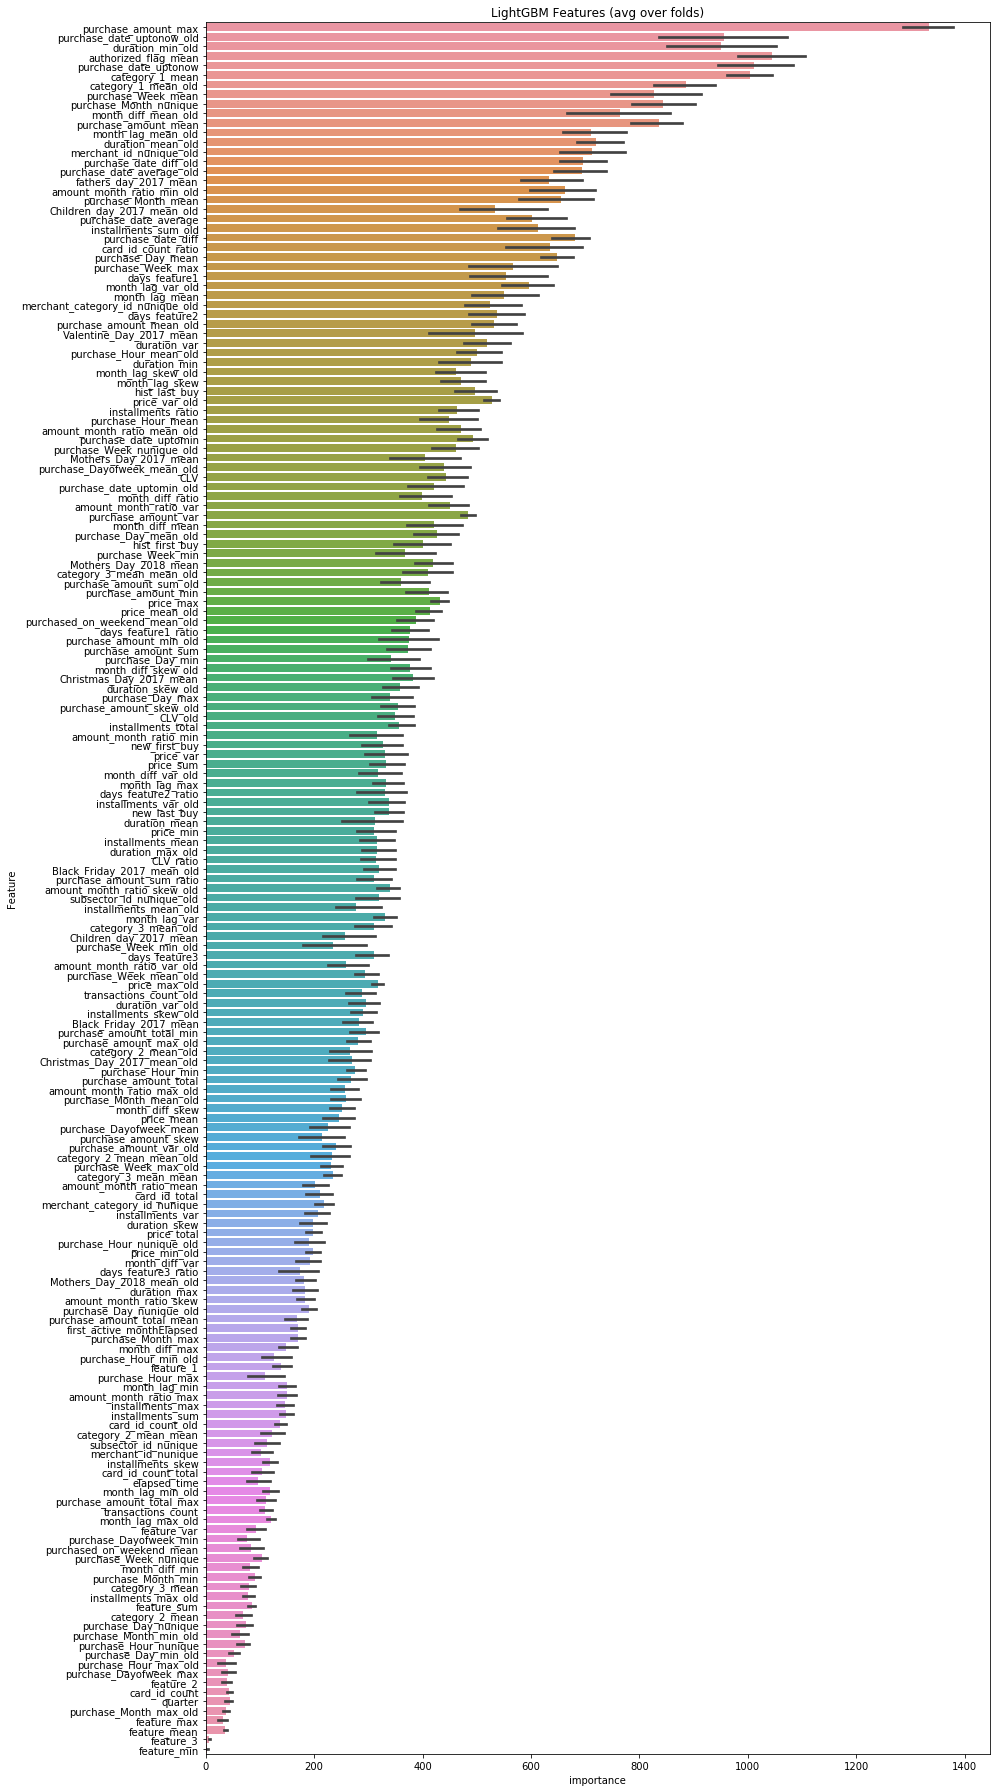

In [13]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [82]:
len(best_features.sort_values(by='importance', ascending=False)[:800]['Feature'].unique())

168

In [120]:
best_features.head(5)

,Feature,importance,fold
0,purchase_amount_max,1003,1
1,duration_min_old,779,1
2,authorized_flag_mean_old,865,1
3,purchase_Week_mean,608,1
4,month_diff_mean_old,637,1


In [ ]:
picked_feats = best_features.sort_values(by='importance', ascending=False)[:800]['Feature'].unique()

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
import gc

In [ ]:
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in cols_excluded]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        submission_name = pd.to_datetime("today")
        sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
        sub_df["target"] = sub_preds
        sub_df.to_csv(f'submission_kfold-{submission_name}.csv', index=False)
#         test_df.loc[:,'target'] = sub_preds
#         test_df = test_df.reset_index()
#         test_df[['card_id', 'target']].to_csv(submission_name, index=False)

In [ ]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
gc.collect()

In [ ]:
kfold_lightgbm(train_df2, test_df2, num_folds=11, stratified=False, debug=False)

In [14]:
submission_name = pd.to_datetime("today")

In [15]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{submission_name}.csv', index=False)

In [17]:
!ls

'Blending submissions.ipynb'
'Elo - ML model - 3.693.ipynb'
'Elo - ML model - 3.695 beta.ipynb'
'Elo - ML model - 3.695.ipynb'
'Elo - ML model - 3.696.ipynb'
'Elo - ML model - beta.ipynb'
'Elo - ML model - cat aggregates.ipynb'
'Elo - ML model clean.ipynb'
'Elo - ML model proc_df.ipynb'
'Elo - ML model-RF copy.ipynb'
'Elo - ML model-backup.ipynb'
'Elo - ML model-new.ipynb'
'Elo RF- New.ipynb'
'Elo RF.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering - 3.696.ipynb'
'Elo feature engineering 3.693 .ipynb'
'Elo feature engineering 3.695 beta.ipynb'
'Elo feature engineering 3.695.ipynb'
'Elo feature engineering beta.ipynb'
'Elo feature engineering using agg.ipynb'
'Elo feature engineering-backup.ipynb'
'Elo feature engineering-proc_df - new-Copy1.ipynb'
'Elo feature engineering-proc_df - new.ipynb'
'Elo feature engineering-proc_df-OLD.ipynb'
'Elo feature engineering-proc_df.ipynb'
'Elo merchant category reco - using RF.ipynb'
'Elo outlier predictions & blending .ipynb'
'Feature selectio

In [18]:
FileLink(f'submission-{submission_name}.csv')

/home/chandrasekhar/private/kaggle/submission-2019-02-13 22:48:45.005871.csv

### Blend

In [79]:
p1 = pd.read_csv(f'submission-{submission_name}.csv')
p2 = pd.read_csv('submission-2019-02-02 23:13:59.670630.csv')

In [80]:
p1.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.960024
1,C_ID_130fd0cbdd,-0.421305
2,C_ID_b709037bc5,-1.011111
3,C_ID_d27d835a9f,-0.141994
4,C_ID_2b5e3df5c2,-1.270823


In [81]:
p2.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.072875
1,C_ID_130fd0cbdd,-0.348145
2,C_ID_b709037bc5,-0.949767
3,C_ID_d27d835a9f,-0.149493
4,C_ID_2b5e3df5c2,-1.212316


In [83]:
p3 = p1.copy()

In [84]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.960024
1,C_ID_130fd0cbdd,-0.421305
2,C_ID_b709037bc5,-1.011111
3,C_ID_d27d835a9f,-0.141994
4,C_ID_2b5e3df5c2,-1.270823


In [102]:
p3 = pd.DataFrame({"card_id":test_df2["card_id"].values})
p3["target"] = p1['target']*.5 + p2['target']*.5

In [103]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.016449
1,C_ID_130fd0cbdd,-0.384725
2,C_ID_b709037bc5,-0.980439
3,C_ID_d27d835a9f,-0.145743
4,C_ID_2b5e3df5c2,-1.241569


In [104]:
p3.to_csv('blend_kfol_st.csv',index=False)

In [47]:
message = 'using blend kfold + stratified, purchase amount trimmed'

In [106]:
p3.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.016449
1,C_ID_130fd0cbdd,-0.384725
2,C_ID_b709037bc5,-0.980439
3,C_ID_d27d835a9f,-0.145743
4,C_ID_2b5e3df5c2,-1.241569


In [16]:
filename = f'submission-{submission_name}.csv'

In [17]:
filename

'submission-2019-02-15 18:08:33.904515.csv'

In [18]:
!kaggle competitions submit elo-merchant-category-recommendation -f 'submission-2019-02-15 18:08:33.904515.csv' -m 'better be good'

100%|#######################################| 4.24M/4.24M [00:21<00:00, 203kB/s]
Successfully submitted to Elo Merchant Category Recommendation

In [36]:
train = train_df2.copy()
train['rounded_target'] = train['target'].round(0)
train = train.sort_values('rounded_target').reset_index(drop=True)
vc = train['rounded_target'].value_counts()
vc = dict(sorted(vc.items()))
df = pd.DataFrame()
train['indexcol'],i = 0,1
for k,v in vc.items():
    step = train.shape[0]/v
    indent = train.shape[0]/(v+1)
    df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
    for j in range(0, v):
        df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
    df = pd.concat([df2,df])
    i+=1

In [37]:
train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)

In [38]:
train.head().T

,0,1,2,3,4
first_active_month,2017-12-01 00:00:00,2016-12-01 00:00:00,2016-09-01 00:00:00,2017-11-01 00:00:00,2017-11-01 00:00:00
card_id,C_ID_176ecc65bd,C_ID_6082929d3a,C_ID_a87bbd85a7,C_ID_92e4809531,C_ID_d2dd6bbf9a
feature_1,0.0131446,0.0107116,0.0104794,0.00805849,0.0107116
feature_2,0.0113848,0.0113848,0.0113848,0.0113848,0.0113848
feature_3,0.0114275,0.0102828,0.0114275,0.0102828,0.0102828
target,-0.279039,-0.926039,0.475326,0.516026,-0.100927
first_active_monthYear,2017,2016,2016,2017,2017
first_active_monthMonth,12,12,9,11,11
first_active_monthWeek,48,48,35,44,44
first_active_monthDay,1,1,1,1,1
